In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import dynamiqs as dq
import jax
import jax.numpy as jnp

# %matplotlib qt
%matplotlib inline

ModuleNotFoundError: No module named 'optax'

In [9]:
# Parameters for device
ntr1 = 2
ntr2 = 2
chi = -2.5*2*jnp.pi # MHz - Frequency units are MHZ, we will work in a frame 
                    # rotating with qubit at the qubit frequency, freq is zero

a1, a1dag = dq.destroy(ntr1), dq.create(ntr1)
a2, a2dag = dq.destroy(ntr2), dq.create(ntr2)
id1 = dq.eye(ntr1)
id2 = dq.eye(ntr2)

# Initial state and expectation values to calculate
psi0 = [dq.tensor(dq.basis(ntr1, 0), dq.basis(ntr2, 0))]
e_ops = [dq.tensor(dq.proj(dq.basis(ntr1, 0)),id2), 
         dq.tensor(dq.proj(dq.basis(ntr1, 1)), id2),
         dq.tensor(id1, dq.proj(dq.basis(ntr2, 0))), 
         dq.tensor(id1, dq.proj(dq.basis(ntr2, 1)))]

tpulse = jnp.linspace(0,2,201)
tsave = jnp.linspace(0,2,201)

# Hamiltonian
H0 = chi*dq.tensor(a1dag@a1, a2dag@a2)

# we are setting the drive amplitude of qubit 2 to zero
Ht1r = dq.pwc(tpulse, 2*jnp.ones(len(tpulse)-1), dq.tensor(a1 + a1dag, id2))
Ht1i = dq.pwc(tpulse, 2*jnp.ones(len(tpulse)-1), -1j*dq.tensor(a1 - a1dag, id2))
Ht2r = dq.pwc(tpulse, 0*jnp.ones(len(tpulse)-1), dq.tensor(id1, a2 + a2dag))
Ht2i = dq.pwc(tpulse, 0*jnp.ones(len(tpulse)-1), -1j*dq.tensor(id1, a2 - a2dag))

Hdrive = Ht1r + Ht1i + Ht2r + Ht2i

H = H0 + Hdrive

# Solve Schrodinger equation
options = dq.Options(progress_meter = None)
solver = dq.method.Tsit5(max_steps = int(1e9))
evo_result = dq.sesolve(H, psi0, tsave, exp_ops = e_ops, method = solver, options = options) 

|██████████| 100.0% ◆ elapsed 14.57ms ◆ remaining 0.00ms


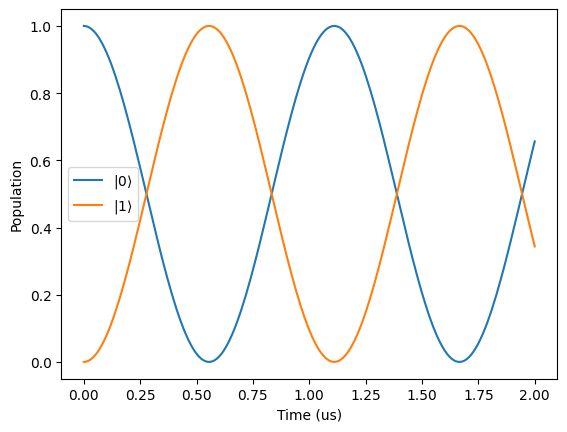

In [12]:
pops = evo_result.expects.real

# Plot 1 shows the dynamics in qubit 1
plt.figure()
plt.plot(tsave, pops[0, 0, :], label = "$|0\\rangle$")
plt.plot(tsave, pops[0, 1, :], label = "$|1\\rangle$")
plt.xlabel("Time (us)")
plt.ylabel("Population")
plt.legend()
plt.show()

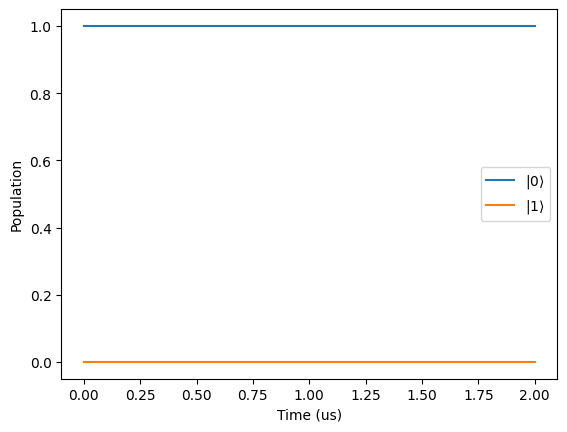

In [13]:
# Plot 2 shows the dynamics in qubit 2
plt.figure()
plt.plot(tsave, pops[0, 2, :], label = "$|0\\rangle$")
plt.plot(tsave, pops[0, 3, :], label = "$|1\\rangle$")
plt.xlabel("Time (us)")
plt.ylabel("Population")
plt.legend()
plt.show()

In [ ]:
# GRAPE style pulse shaping:

T= 0.1
nsteps = 21
ntsave = 101

tpulse = jnp.linspace(0,T,nsteps)
tsave = jnp.linspace(0,T,ntsave)

optimizer = optax.adam(learning_rate)

opt_state = optimizer.init(amps)
losses = []